In [2]:
import os
import pandas as pd
import time
import seaborn as sns
from pandas import read_csv, DataFrame
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt

path = os.getcwd()

plt.rcParams.update({'axes.labelsize': 15, 'axes.titlesize': 15, 
              'legend.fontsize':13, 'font.family': ['sans-serif'] })

##### DESCRIPCIÓN

Previamente se cuenta con un archivo .csv de observaciones de asteroides obtenidos de Gaia DR2, arreglado y completado con información como los parámetros R, Delta y Phase, y la magnitud de gaia reducida. 

Con este código se termina de completar los datos (parámetros orbitales, H y G) mediante querys a JPL Horizon, se seleccionan unicamente los troyanos de Júptier a partir de la info sobre el semieje mayor, se halla la magnitud V de Johnson reducida y se guarda finalmente en el archivo _Gaia_DR2_trojans.csv_


In [2]:
df = read_csv(path+"/Datos_Gaia/Gaia_DR2.csv")
df

,number_mp,jd,g_mag,r,delta,alpha,g_mag_red
0,8,2.456955e+06,10.480866,2.064176,2.135195,27.5988,7.259945
1,8,2.456982e+06,10.165281,2.113121,1.862361,28.1829,7.190340
2,8,2.457141e+06,10.486789,2.383389,1.938377,24.5397,7.163623
3,8,2.457171e+06,10.903569,2.423949,2.354853,24.6839,7.121133
4,8,2.457171e+06,10.883524,2.424042,2.355865,24.6799,7.100071
...,...,...,...,...,...,...,...
131213,159493,2.457450e+06,19.015087,2.781115,2.107374,17.5771,15.175284
131214,159493,2.457523e+06,18.998713,2.946188,2.134202,14.1819,15.006232
131215,159493,2.457523e+06,19.149148,2.946656,2.136485,14.2301,15.154001
131216,159493,2.457524e+06,19.199903,2.947123,2.138780,14.2781,15.202081


### Completar información

Se añaden los parámetros orbitales:

- Semieje mayor (a)
- Inclinación (i)
- Excentricidad (e)

Para ahorrar tiempo, solo se hace una query por asteroide y se copia esa información al resto de observaciones del mismo

In [ ]:
####################################      Parámetros orbitales      ####################################      

inicio = time.time()

number_before=1
for i in range(len(df)):   
    number = df['number_mp'].values[i]
    
    if number == number_before:
        df.loc[i,'a_orb'] = ast['a']
        df.loc[i,'e_orb'] = ast['e']
        df.loc[i,'i_orb'] = ast['incl']
        print(df.loc[i,['number_mp','a_orb','e_orb','i_orb']])

    else:
        ast = Horizons(id=number)  
        ast = ast.elements()
        df.loc[i,'a_orb'] = ast['a']
        df.loc[i,'e_orb'] = ast['e']
        df.loc[i,'i_orb'] = ast['incl']
        print(df.loc[i,['number_mp','a_orb','e_orb','i_orb']])
        
        number_before = number 
    
fin = time.time()
tiempo = fin-inicio
print('Tiempo de ejecución del programa (s):', tiempo)


Se añade información de los parámetros de la Función de fase

In [ ]:
###########################################    H y G     ############################################       

inicio = time.time()


number_before = 1
for i in range(len(df)):   
    number = df['number_mp'].values[i]
    
    if number == number_before:
        df.loc[i,'H'] = ast['H']
        df.loc[i,'G'] = ast['G']
        print(df.loc[i,['number_mp','H','G']])
    
    else:
        ast = Horizons(id=number)  
        ast = ast.elements()
        df.loc[i,'H'] = ast['H']
        df.loc[i,'G'] = ast['G']
        print(df.loc[i,['number_mp','H','G']])
        
        number_before=number 
    
fin = time.time()
tiempo = fin-inicio
print('Tiempo de ejecución del programa (s):', tiempo)

### Determinar magnitud V de Johnson

~~~
V_Johnson = mag_gaia_red + 0.02269 - 0.01784VR + 1.016VR^2 - 0.2225VR^3
~~~

siendo VR = 0.45 (Jewitt 2017)

In [ ]:
VR = 0.45   

df['V'] = df['g_mag_red'] + 0.02269 - 0.01784*VR + 1.016*VR*VR - 0.2225*VR*VR*VR

### Renombrar columnas

Para que coincidan con el catálogo de SLOAN a la hora de concatenar

- Distancia al observador (r) pasa a ser 'Delta' (como en JPL)
- Distancia heliocéntrica (delta) pasa a ser 'R' (como en JPL)
- 'number_mp' a 'Number' como se muestra en SLOAN
- 'g_mag' y 'g_mag_red' a 'gaia_mag' y 'gaia_mag_red' para no confundir con la magnitud g de SLOAN
- 'alpha' a 'Phase' como en SLOAN

In [ ]:
df.rename(columns={'r': 'Delta', 'delta': 'R', 'number_mp':'Number', 
                   'g_mag':'gaia_mag', 'g_mag_red':'gaia_mag_red', 
                   'alpha':'Phase'}, inplace=True)

### Plot inclinación vs distancia

(1) Gráfico general 

(2) Gráfico hasta troyanos

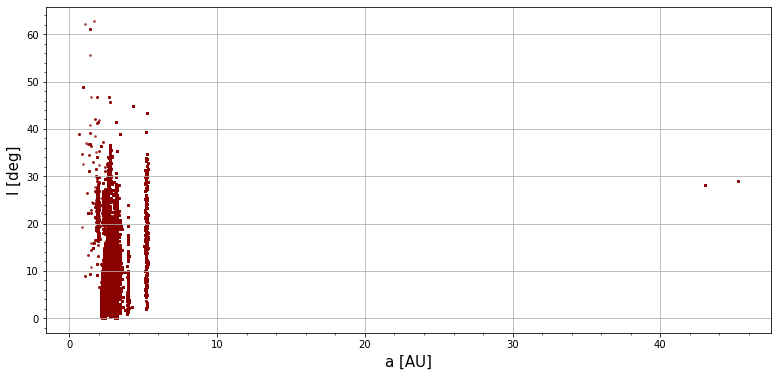

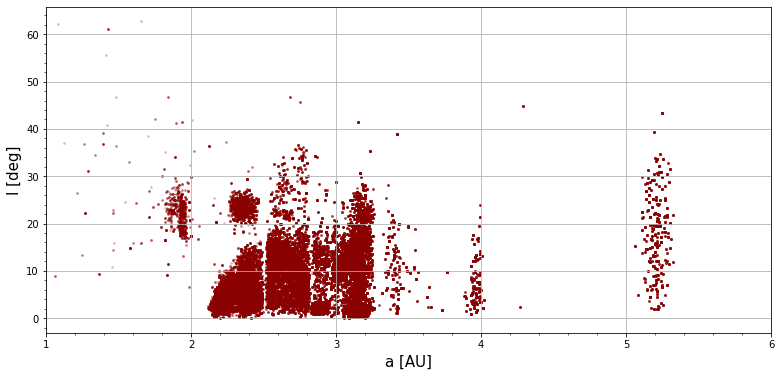

In [5]:
data = df.to_numpy()
i = data[:,9]
a = data[:,7]

fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(a,i, s=3,alpha=0.6,color='darkred')
plt.xlabel(r'a [AU]'); plt.ylabel(r'I [deg]')
plt.minorticks_on()
plt.grid()

fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(a,i, s=3,alpha=0.2,color='darkred')
plt.xlabel(r'a [AU]'); plt.ylabel(r'I [deg]')
plt.xlim(1,6)
plt.minorticks_on()
plt.grid()
plt.show() 

Se guardan los datos completos de todos los asteroides 

In [ ]:
df.to_csv(path+"/Datos_Gaia/Gaia_DR2_completed.csv",index=False)

## Troyanos

A partir del semieje mayor, a, se eliminan todos los asteroides que no sean troyanos de Júpiter

In [ ]:
df.drop(df[df['a_orb'] > 5.6].index, inplace = True)
df.drop(df[df['a_orb'] < 4.8].index, inplace = True)

### Histograma magnitudes

Magnitud V de Johnson y magnitud gaia reducida

In [12]:
df

,Number,jd,gaia_mag,Delta,R,Phase,gaia_mag_red,a_orb,e_orb,i_orb,H,G,V
0,588,2.456892e+06,16.122210,5.397643,6.057591,7.8178,8.549690,5.209202,0.147923,10.319917,8.26,0.15,8.734876
1,588,2.456892e+06,16.200622,5.397720,6.058477,7.8101,8.627753,5.209202,0.147923,10.319917,8.26,0.15,8.812940
2,588,2.456892e+06,16.139169,5.397903,6.060584,7.7916,8.565471,5.209202,0.147923,10.319917,8.26,0.15,8.750658
3,588,2.456893e+06,16.175029,5.397980,6.061467,7.7839,8.600984,5.209202,0.147923,10.319917,8.26,0.15,8.786171
4,588,2.456893e+06,16.120776,5.398240,6.064449,7.7575,8.545558,5.209202,0.147923,10.319917,8.26,0.15,8.730745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777,76867,2.457419e+06,17.845379,5.239495,4.570042,8.6229,10.949331,5.166796,0.030463,28.762692,10.49,0.15,11.134518
2778,76867,2.457490e+06,18.347929,5.252890,5.542083,10.3106,11.027573,5.166796,0.030463,28.762692,10.49,0.15,11.212760
2779,76867,2.457491e+06,18.402108,5.252922,5.544453,10.3015,11.080810,5.166796,0.030463,28.762692,10.49,0.15,11.265997
2780,76867,2.457511e+06,18.369056,5.256612,5.798911,8.9502,10.948794,5.166796,0.030463,28.762692,10.49,0.15,11.133981


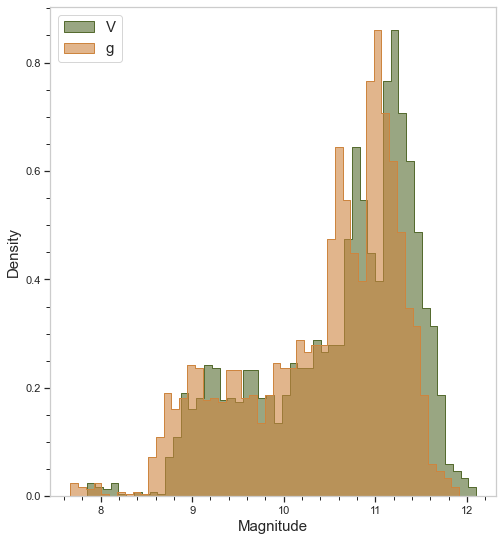

In [11]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,9))
g = sns.histplot(data=df, x="V", bins=50, 
             color='darkolivegreen', alpha=0.6, 
             element='step',stat="density", common_norm=False, label='V')
sns.histplot(data=df, x="gaia_mag_red", bins=50, 
             color='peru', alpha=0.6,  
             element='step',stat="density", common_norm=False, label='g')

g.set_xlabel("Magnitude", fontsize = 15)
g.set_ylabel("Density", fontsize = 15)
plt.legend(loc='upper left', fontsize=15)
plt.grid(False)
plt.minorticks_on()
ax.tick_params(which='both', bottom=True, left=True)

Se reordenan las columnas para que coincidan con las de los otros catálogos y se guarda

In [16]:
df = df.reindex(columns=['Number', 'jd', 'gaia_mag', 'a_orb', 'e_orb', 'i_orb', 'Delta','R', 'Phase',  
                         'H', 'G', 'gaia_mag_red', 'V' ])

df.to_csv(path+"/Datos_Gaia/Gaia_DR2_trojans.csv",index=False)